In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/drive/MyDrive/dataset /content/

In [ ]:
import os
os.listdir('/content/dataset')

['no-caries', '.DS_Store', 'caries']

In [ ]:
Image_size=256
Batch_size=32
Channel= 3
epochs=10

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers


In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 1554 files belonging to 2 classes.


In [ ]:
class_names= dataset.class_names
class_names

['caries', 'no-caries']

In [ ]:
len(dataset)

49

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0]


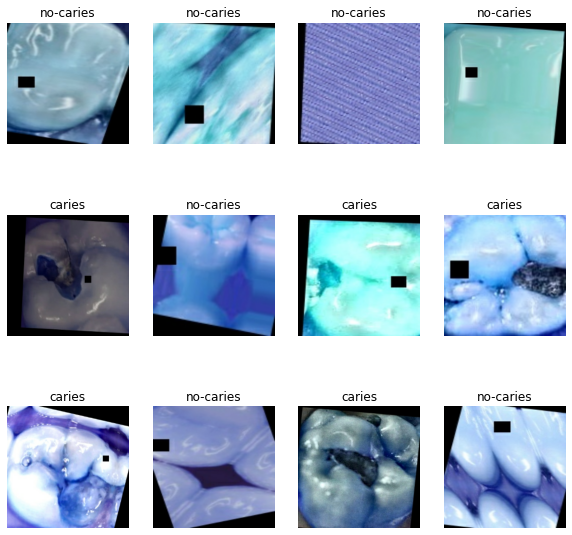

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4, i+1)
    image = image_batch[i].numpy().astype("uint8")
    plt.imshow(image)
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
  

In [ ]:
train_size=0.8
len(dataset)*train_size

39.2

In [ ]:
train_ds=dataset.take(39)
len(train_ds)

39

In [ ]:
test_ds=dataset.skip(39)
len(test_ds)

10

In [ ]:
val_size=0.1
len(dataset)*val_size

4.9

In [ ]:
test_ds=test_ds.skip(5)
len(test_ds)

5

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

  ds_size= len(ds)

  if shuffle:
    ds= ds.shuffle(shuffle_size, seed=12)
  
  train_size=int(train_split * ds_size)
  val_size= int(val_split * ds_size)

  train_ds= ds.take(train_size)

  val_ds= ds.skip(train_size).take(val_size)
  test_ds= ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

39

In [ ]:
len(val_ds)

4

In [ ]:
len(test_ds)

6

In [ ]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [ ]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape=(Batch_size,Image_size, Image_size, Channel)
n_classes=3
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [ ]:
from keras.api._v2.keras.losses import SparseCategoricalCrossentropy
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, name='sparse_categorical_crossentropy'),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
39/39 [==============================] - 194s 5s/step - loss: 0.5831 - accuracy: 0.7431 - val_loss: 0.4756 - val_accuracy: 0.7812
Epoch 2/10
39/39 [==============================] - 188s 5s/step - loss: 0.4697 - accuracy: 0.7885 - val_loss: 0.4270 - val_accuracy: 0.8125
Epoch 3/10
39/39 [==============================] - 195s 5s/step - loss: 0.4329 - accuracy: 0.7836 - val_loss: 0.4797 - val_accuracy: 0.7188
Epoch 4/10
39/39 [==============================] - 188s 5s/step - loss: 0.4010 - accuracy: 0.8209 - val_loss: 0.3856 - val_accuracy: 0.8359
Epoch 5/10
39/39 [==============================] - 188s 5s/step - loss: 0.3930 - accuracy: 0.8185 - val_loss: 0.3799 - val_accuracy: 0.8203
Epoch 6/10
39/39 [==============================] - 196s 5s/step - loss: 0.3724 - accuracy: 0.8347 - val_loss: 0.3803 - val_accuracy: 0.8359
Epoch 7/10
39/39 [==============================] - 188s 5s/step - loss: 0.3743 - accuracy: 0.8250 - val_loss: 0.3917 - val_accuracy: 0.8203
Epoch 8/10
39

In [ ]:
scores= model.evaluate(test_ds)

6/6 [==============================] - 12s 2s/step - loss: 0.4201 - accuracy: 0.7969


In [ ]:
scores

[0.4200991690158844, 0.796875]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 39}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.7431118488311768,
 0.7884926795959473,
 0.7836304903030396,
 0.8209075927734375,
 0.8184764981269836,
 0.8346839547157288,
 0.8249594569206238,
 0.8427876830101013,
 0.8363047242164612,
 0.8589951395988464]

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

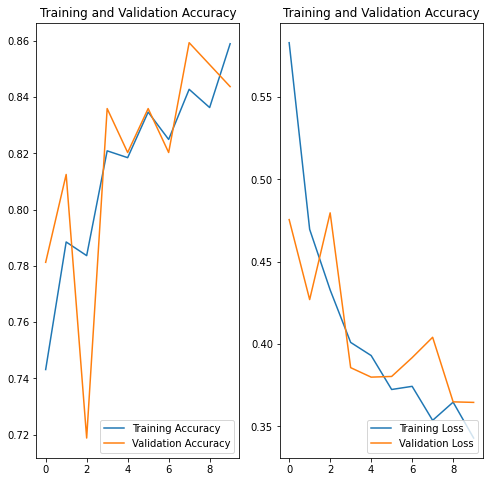

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(epochs),loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
first image's actual label: caries
1/1 [==============================] - 2s 2s/step
predicted label: caries


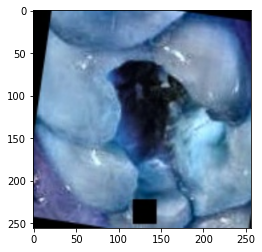

In [ ]:
for image_batch, labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype("uint8")
  #plt.imshow(image)
  first_label=labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", class_names[first_label])

  batch_prediction= model.predict(image_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model,img):
  img_array= tf.keras.preprocessing.image.img_to_array(image[i].numpy())
  img_array= tf.expand_dims(img_array, 0)

  prediction= model.predict(img_array)

  predicted_class= class_names[np.argmax(prediction[0])]
  confidence=round(100*(np.max(prediction[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 53ms/step


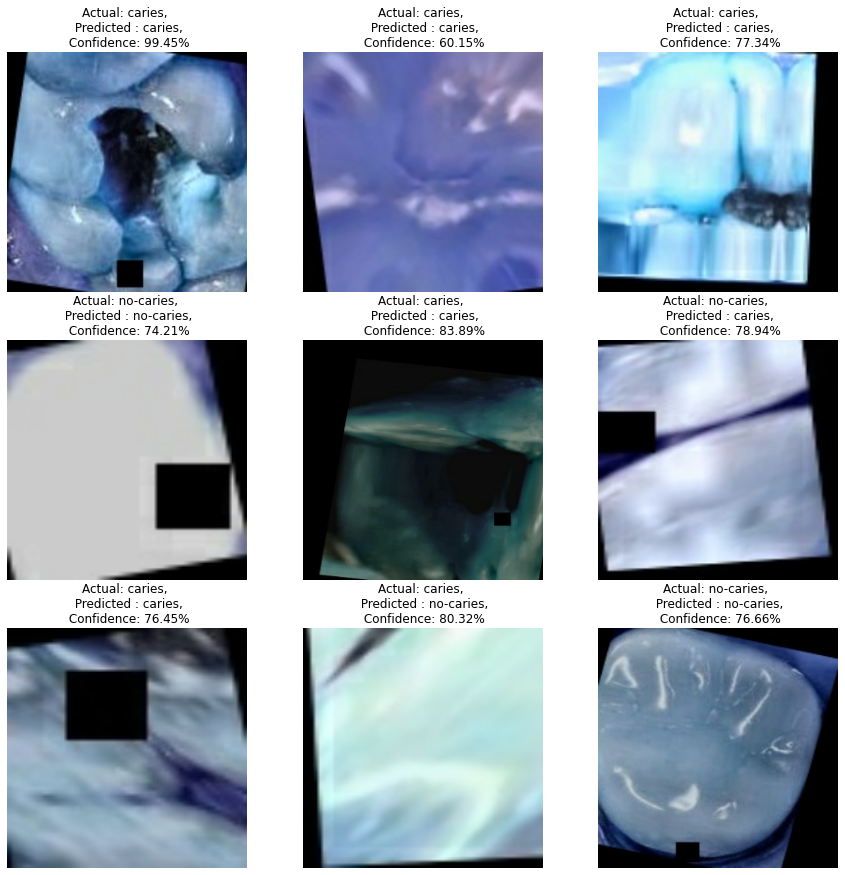

In [ ]:
plt.figure(figsize=(15,15))
for image, labels in test_ds.take(1):
  for i in range(9):
    ax= plt.subplot(3,3,i+1)
    image_=image_batch[i].numpy().astype("uint8")
    plt.imshow(image_)

    predicted_class, confidence= predict(model, image[i].numpy())
    actual_class= class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted : {predicted_class},\n Confidence: {confidence}%")
    plt.axis("off")

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#model_version=1
model.save('TeethDecayKerasPredcition.h5')

In [ ]:
file = drive.CreateFile({'title': 'TeethDecayKerasPredcition.h5'})
file.Upload()